### Multiple faces emotion recognition using the trained model
> - __For fer2013 model training you can check this [notebook](./emotion_recognition_training_fer.ipynb)__
> - __For a simple demo about how to do realtime face tracking check this [notebook](../src/realtime_face_detection_demo.ipynb)__

__What we need to do here is to do multiple face emtion recognition, this means doing:__
1. Extracting faces from an image using haarcascade (As our model trained in a cropped faces)
1. Crop this face
1. Make emotion recognition using our trained model

### Notebook roadmap
__1. Model usage part:__
a. Loading the emotion recognition model.
b. Loading an image with cropped face and do use the model on it.

__2. Face detection part__
a. Load an image then gets the face position on it.
b. Use these positions to crop to the face only
c. Use the model for predictions

__3. Generalize this to multiple faces in a single image__


### 1. Load the trained model

In [1]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
model = keras.models.load_model('../models/fer_best.h5')

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       2

### Trying the model on a single image
1. Read an image
2. detect face on it and crop to the face
3. preprocess the cropped image
4. make prediction in this image

#### 1. Loading an image and predicting its emotino

(1, 48, 48, 1)


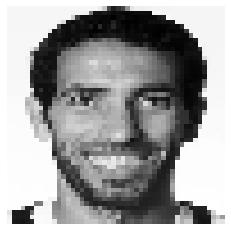

In [4]:
img = cv2.imread('../assets/aboutrika-happy.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (48, 48))
img = img/255.0
img = np.expand_dims(img, -1)
img = np.expand_dims(img, axis=0)

print(img.shape)
# print(type(img))

plt.imshow(img[0], cmap='gray')
plt.axis('off')
plt.show()

In [5]:
emotions = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy',
            4: 'neutral', 5: 'sad', 6: 'surprise'}


In [6]:
preds = model.predict(img)
print(f'Getting a class: {emotions[np.argmax(preds)]} with prob: {round((np.max(preds) * 100), 2)}')

Getting a class: happy with prob: 99.7


#### 2. Detecting only the face from a large image and predicting its emotion
__A) Instantiate the haarcascade for face detection__

In [7]:
face_cascade = cv2.CascadeClassifier()

In [8]:
face_cascade.load(cv2.data.haarcascades + 
                 './haarcascade_frontalface_default.xml')

True

B) __Detect a face from a single image and predict it__

In [9]:
def show_img(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

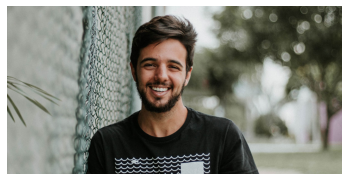

In [10]:
big_img = cv2.imread('../assets/happyPerson.jpeg')
big_img = cv2.cvtColor(big_img, cv2.COLOR_BGR2RGB)
show_img(big_img)

- __note that in the above image the face represent a small portion of the image__
- So the plan is to detect only the face from the whole image then make preds on it

### __Face detection and prediction__

In [11]:
face_pos = face_cascade.detectMultiScale(big_img, 3, 10)

In [12]:
face_pos

array([[446, 130, 216, 216]], dtype=int32)

In [13]:
x, y, w, h = face_pos[0]
print(x, y, w, h)

446 130 216 216


In [14]:
croped_img = big_img[y:y+h, x:x+h]

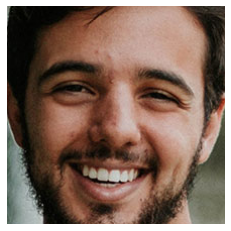

In [15]:
show_img(croped_img)

In [16]:
croped_img.shape

(216, 216, 3)

In [17]:
def face_processing(face):
    face = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)
    face = cv2.resize(face, (48, 48))
    face = np.expand_dims(face, axis=0)
    face = np.expand_dims(face, -1)     
#     print(face.shape)
    
    face = face / 255.0
    
    return face

In [18]:
face = face_processing(croped_img)

In [19]:
def get_preds(face):
    preds = model.predict(face)
    
    emotion = emotions[np.argmax(preds)]
    prob = round(np.max(preds) * 100, 2)

    return emotion, prob

In [20]:
label, prob = get_preds(face)

In [21]:
print(f'Emotion: {label}, with prob: {prob}')

Emotion: happy, with prob: 99.63


__Putting a rectangle with a label around the face__

In [22]:
for (x, y, w, h) in face_pos:
    cv2.rectangle(big_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

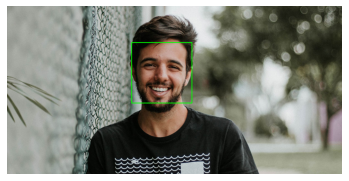

In [23]:
show_img(big_img)

In [24]:
big_img = cv2.putText(big_img, label, (x-10, y-10),
                cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), thickness=2)

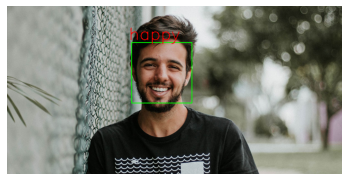

In [25]:
show_img(big_img)

### Detecting multiple faces and predicting emotions for them

In [26]:
def load_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = np.float32(img)
    
    return img

In [27]:
arab_players = load_img('../assets/arab_players.jpg')

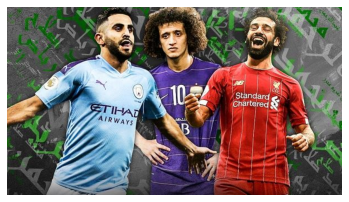

In [28]:
show_img(arab_players)

In [29]:
def face_emotion_detection(img):
    face_poses = face_cascade.detectMultiScale(arab_players, 1.1, 4)
    
    # looping over all faces in single img
    for (x, y, w, h) in face_poses:
        # draw rect
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # crop the face or faces
        face = img[y:y+h, x:x+h]
        
        # preprocess it 
        face = face_processing(face)
        
        # predict 
        label, prob = get_preds(face)
        
        # Put the label
        cv2.putText(img, label, (x+10, y+10),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), thickness=2)
        

In [32]:
face_emotion_detection(arab_players)

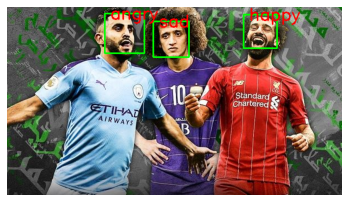

In [33]:
show_img(arab_players)

### __DONE now we have a multiple face emotion detection algorithm__
__The next step is to do this in realtime__